In [2]:
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
np.set_printoptions(threshold=np.inf)
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import math
import time
from scipy import ndimage
#import edge_detection from edge_detection
from read_image import image_read

In [3]:
class Piece:
    def _init_(color, rot_arr):
        
        #rot_arr: -1  = inward piece
        #          0  = flat edge
        #          1  = outward piece
        #first cell is top edge, next continues clockwise
        #
        self.color = color
        self.rot_arr = rot_arr
        self.edges = edge_detection(color, 50, 150)
        
        zero_count = 0 
        for x in range(len(rot_arr)):
            if(rot_arr[x] == 0):
                zero_count += 1
                
        if(zero_count == 2):
            self.typ = "corner"
        elif(zero_count == 1):
            self.typ  = "edge"
        else:
            self.typ = "inner"    
        
    
def rotate(img):
        rows,cols = img.shape
        M = cv.getRotationMatrix2D((cols/2,rows/2),-90,1)
        dst = cv.warpAffine(img,M,(cols,rows))  
            
        return dst

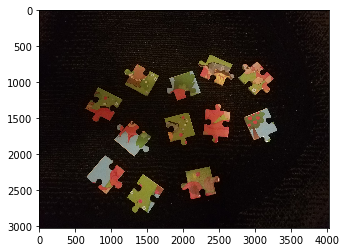

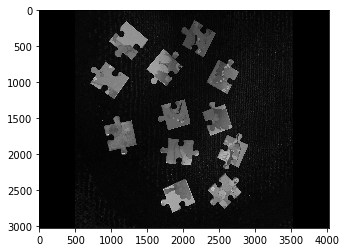

In [8]:
t = image_read("test.bmp")
plt.imshow(t, cmap = plt.get_cmap('gray'))
plt.show()
tn = rgb2gray(t)
new = rotate(tn)
plt.imshow(new, cmap = plt.get_cmap('gray'))
plt.show()

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [13]:
class matchers:
    def __init__(self):
        self.surf = cv.xfeatures2d.SURF_create()
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=0, trees=5)
        search_params = dict(checks=50)
        self.flann = cv.FlannBasedMatcher(index_params, search_params)

    def match(self, i1, i2, direction=None):
        imageSet1 = self.getSURFFeatures(i1)
        imageSet2 = self.getSURFFeatures(i2)
        print("Direction : "+ direction)
        matches = self.flann.knnMatch(
            imageSet2['des'],
            imageSet1['des'],
            k=2
            )
        good = []
        for i , (m, n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                good.append((m.trainIdx, m.queryIdx))

        if len(good) > 4:
            pointsCurrent = imageSet2['kp']
            pointsPrevious = imageSet1['kp']

            matchedPointsCurrent = np.float32(
                [pointsCurrent[i].pt for (__, i) in good]
            )
            matchedPointsPrev = np.float32(
                [pointsPrevious[i].pt for (i, __) in good]
                )
            H, s = cv.findHomography(matchedPointsCurrent, matchedPointsPrev, cv.RANSAC, 4)
            return H
        return None

    def getSURFFeatures(self, im):
        gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        kp, des = self.surf.detectAndCompute(gray, None)
        return {'kp':kp, 'des':des}

In [21]:
import numpy as np
import cv2
import sys
import time

class Stitch:
	def __init__(self, args):
		'''self.path = args
		fp = open(self.path, 'r')
		filenames = [each.rstrip('\r\n') for each in  fp.readlines()]
		print(filenames)
		self.images = [cv2.resize(cv2.imread(each),(480, 320)) for each in filenames]
		self.count = len(self.images)
		self.left_list, self.right_list, self.center_im = [], [],None
		self.matcher_obj = matchers()
		self.prepare_lists()'''

	def prepare_lists(self):
		print("Number of images : %d"%self.count)
		self.centerIdx = self.count/2 
		print("Center index image : %d"%self.centerIdx)
		self.center_im = self.images[int(self.centerIdx)]
		for i in range(self.count):
			if(i<=self.centerIdx):
				self.left_list.append(self.images[i])
			else:
				self.right_list.append(self.images[i])
		print("Image lists prepared")

	def leftshift(self):
		# self.left_list = reversed(self.left_list)
		a = self.left_list[0]
		for b in self.left_list[1:]:
			H = self.matcher_obj.match(a, b, 'left')
			print("Homography is : ", H)
			xh = np.linalg.inv(H)
			print("Inverse Homography :", xh)
			ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
			ds = ds/ds[-1]
			print("final ds=>", ds)
			f1 = np.dot(xh, np.array([0,0,1]))
			f1 = f1/f1[-1]
			xh[0][-1] += abs(f1[0])
			xh[1][-1] += abs(f1[1])
			ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))
			offsety = abs(int(f1[1]))
			offsetx = abs(int(f1[0]))
			dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety)
			print("image dsize =>", dsize)
			tmp = cv2.warpPerspective(a, xh, dsize)
			# cv2.imshow("warped", tmp)
			# cv2.waitKey()
			tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
			a = tmp

		self.leftImage = tmp

		
	def rightshift(self):
		for each in self.right_list:
			H = self.matcher_obj.match(self.leftImage, each, 'right')
			print("Homography :", H)
			txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
			txyz = txyz/txyz[-1]
			dsize = (int(txyz[0])+self.leftImage.shape[1], int(txyz[1])+self.leftImage.shape[0])
			tmp = cv2.warpPerspective(each, H, dsize)
			cv2.imshow("tp", tmp)
			cv2.waitKey()
			# tmp[:self.leftImage.shape[0], :self.leftImage.shape[1]]=self.leftImage
			tmp = self.mix_and_match(self.leftImage, tmp)
			print("tmp shape",tmp.shape)
			print("self.leftimage shape=", self.leftImage.shape)
			self.leftImage = tmp
		# self.showImage('left')



	def mix_and_match(self, leftImage, warpedImage):
		i1y, i1x = leftImage.shape[:2]
		i2y, i2x = warpedImage.shape[:2]
		print(leftImage[-1,-1])

		t = time.time()
		black_l = np.where(leftImage == np.array([0,0,0]))
		black_wi = np.where(warpedImage == np.array([0,0,0]))
		print(time.time() - t)
		print(black_l[-1])

		for i in range(0, i1x):
			for j in range(0, i1y):
				try:
					if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
						# print "BLACK"
						# instead of just putting it with black, 
						# take average of all nearby values and avg it.
						warpedImage[j,i] = [0, 0, 0]
					else:
						if(np.array_equal(warpedImage[j,i],[0,0,0])):
							# print "PIXEL"
							warpedImage[j,i] = leftImage[j,i]
						else:
							if not np.array_equal(leftImage[j,i], [0,0,0]):
								bw, gw, rw = warpedImage[j,i]
								bl,gl,rl = leftImage[j,i]
								# b = (bl+bw)/2
								# g = (gl+gw)/2
								# r = (rl+rw)/2
								warpedImage[j, i] = [bl,gl,rl]
				except:
					pass
		# cv2.imshow("waRPED mix", warpedImage)
		# cv2.waitKey()
		return warpedImage




	def trim_left(self):
		pass

	def showImage(self, string=None):
		if string == 'left':
			cv2.imshow("left image", self.leftImage)
			# cv2.imshow("left image", cv2.resize(self.leftImage, (400,400)))
		elif string == "right":
			cv2.imshow("right Image", self.rightImage)
		cv2.waitKey()


if __name__ == '__main__':
	try:
		args = sys.argv[1]
	except:
		args = "txtlists/files1.txt"
	finally:
		print("Parameters : ", args)
	s = Stitch(args)
	s.leftshift()
	# s.showImage('left')
	s.rightshift()
	print("done")
	cv2.imwrite("test12.jpg", s.leftImage)
	print("image written")
	cv2.destroyAllWindows()



Parameters :  -f


AttributeError: 'Stitch' object has no attribute 'left_list'